# Similarity Modeling

## Versions

In [1]:
!python --version
!conda list |grep -E "pandas|numpy|seaborn|librosa|opencv"

Python 3.8.5
libopencv                 4.4.0                    py38_2    conda-forge
librosa                   0.8.0              pyh9f0ad1d_0    conda-forge
numpy                     1.19.2           py38h456fd55_0  
numpy-base                1.19.2           py38hcfb5961_0  
opencv                    4.4.0                    py38_2    conda-forge
pandas                    1.1.3            py38hb1e8313_0  
py-opencv                 4.4.0            py38h23f93f0_2    conda-forge
seaborn                   0.11.0                     py_0  


## Global Vars and Imports

In [437]:
## imports
import pandas as pd
import numpy as np
import librosa as lr
import cv2
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange

from skimage.color import rgb2gray
from skimage import exposure

## vars
check_for_data = True
create_feature_data = True

## Check for Data

In [4]:
if check_for_data == True:
    print("checking for raw movies.mp4 files...")
    files = ["Muppets-02-01-01.avi", "Muppets-02-04-04.avi", "Muppets-03-04-03.avi"]
    for f in files:
        print("../media/"+f)
        os.path.isfile("../media/"+f)
    print("all present!")

checking for raw movies.mp4 files...
../media/Muppets-02-01-01.avi
../media/Muppets-02-04-04.avi
../media/Muppets-03-04-03.avi
all present!


## Load Ground Truth

In [5]:
gt1 = pd.read_csv("../data/gt/gt_02_04_04.csv.csv", delimiter=",", na_values="")
gt1.fillna(0).head()

,Min,Sec,kermit_video,kermit_audio,ws_video,ws_audio
0,0,0,0.0,0,0.0,0.0
1,0,1,0.0,0,0.0,0.0
2,0,2,0.0,0,0.0,0.0
3,0,3,0.0,0,0.0,0.0
4,0,4,0.0,0,0.0,0.0


# HSV

In [7]:
vcap = cv2.VideoCapture('../media/Muppets-02-04-04.avi')
success,image = vcap.read()
count = 0
imgs = []
while success and count < 5000:
#while success:
    #imgs.append(image) # BGR
    imgs.append(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
    success,image = vcap.read()
    count += 1

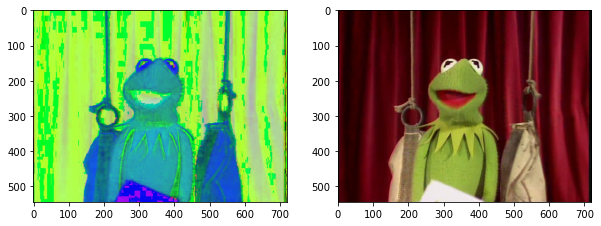

In [160]:
from matplotlib.colors import hsv_to_rgb
#imgs[2750].shape
test = imgs[3250].copy()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(test, cmap="hsv")
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(test, cv2.COLOR_HSV2BGR)[:,:,::-1])


In [573]:
test = imgs[2500].copy()
hue, sat, val = cv2.split(test)
test_rgb = cv2.cvtColor(test, cv2.COLOR_HSV2BGR)
#plt.imshow(saturation, cmap="gray")

# define range of blue color in HSV
lower_green = np.array([20,50,50])
upper_green = np.array([70,255,255])
# Threshold the HSV image to get only blue colors
mask = cv2.inRange(test, lower_green, upper_green)
# Bitwise-AND mask and original image
res = cv2.bitwise_and(test, test, mask=mask)

#plt.imshow(res[:,:,1], cmap="gray")
#plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2HSV)[:,:,1])

hue, sat, val = cv2.split(cv2.cvtColor(res, cv2.COLOR_BGR2HSV))
retval, thresholded = cv2.threshold(sat, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#plt.imshow(thresholded, cmap="gray")

medianFiltered = cv2.medianBlur(thresholded,27)
#plt.imshow(medianFiltered, cmap="gray")

fig, axes = plt.subplots(1, 2, figsize=(8, 7), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(test_rgb[:,:,::-1])

blobs_doh = blob_doh(medianFiltered, max_sigma=150, threshold=0.05)
ax[1].imshow(medianFiltered, cmap="gray")
for blob in blobs_doh:
    y, x, r = blob
    c = plt.Circle((x, y), r, color="red", linewidth=2, fill=False)
    ax[1].add_patch(c)

IndexError: list index out of range

## Load features from AVI

In [581]:
from tqdm import tqdm

def feats_from_avi(fpath="../media/Muppets-02-04-04.avi"):
    print("processing file:", fpath, "...")
    vcap = cv2.VideoCapture(fpath)
    success,image = vcap.read()
    nr_frames = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))
    #count = 0 
    mins = -1
    minflip = False
    seconds = -1
    imgs = []
    feats = pd.DataFrame(columns=["minute", "second", "frame", "blobs", "rgb_hist"])
    #while success and count < 751:
    for count in tqdm(range(0, 50)):
        imgs.append(image) # BGR
        #imgs.append(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
        blobs = return_green_blobs(image)
        color_hists = return_hists(image)
        # handle frame to time stuff
        if (count%25)==0:
            seconds +=1
        if (seconds%60)==0:
            if not minflip:
                minflip=True
                mins+=1
        elif (seconds%60)!=0 & minflip:
            minflip=False
        # append feature blobs to dataframe for current minute, second, frame
        feats = feats.append({"minute":mins, "second": seconds, "frame": count%25+1,
                              "blobs": blobs, "rgb_hist": color_hists}, ignore_index=True)

        success,image = vcap.read()
        count += 1
    
    return(feats)



In [582]:
feats = feats_from_avi()

  2%|▏         | 1/50 [00:00<00:06,  7.00it/s]

processing file: ../media/Muppets-02-04-04.avi ...


100%|██████████| 50/50 [00:05<00:00,  8.99it/s]


## Merge features with GT

In [572]:
pd.merge(feats, gt1, left_on=['minute','second'], right_on = ['Min','Sec'])


,minute,second,frame,blobs,rgb_hist,Min,Sec,kermit_video,kermit_audio,ws_video,ws_audio
0,0,0,1,[],"[[391680.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0,0.0,NaN,NaN,NaN
1,0,0,2,[],"[[391680.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0,0.0,NaN,NaN,NaN
2,0,0,3,[],"[[391680.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0,0.0,NaN,NaN,NaN
3,0,0,4,[],"[[391680.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0,0.0,NaN,NaN,NaN
4,0,0,5,[],"[[391680.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0,0.0,NaN,NaN,NaN
5,0,0,6,[],"[[391680.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0,0.0,NaN,NaN,NaN
6,0,0,7,[],"[[391680.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0,0.0,NaN,NaN,NaN
7,0,0,8,[],"[[391680.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0,0.0,NaN,NaN,NaN
8,0,0,9,[],"[[391680.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0,0.0,NaN,NaN,NaN
9,0,0,10,[],"[[391680.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,0,0.0,NaN,NaN,NaN


In [571]:
feats.head()

,minute,second,frame,blobs,rgb_hist
0,0,0,1,[],"[[391680.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0,0,2,[],"[[391680.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0,0,3,[],"[[391680.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,0,0,4,[],"[[391680.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,0,0,5,[],"[[391680.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [568]:
display(gt1)

,Min,Sec,kermit_video,kermit_audio,ws_video,ws_audio
0,0,0,0.0,NaN,NaN,NaN
1,0,1,0.0,NaN,NaN,NaN
2,0,2,0.0,NaN,NaN,NaN
3,0,3,0.0,NaN,NaN,NaN
4,0,4,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...
1555,25,55,NaN,NaN,NaN,NaN
1556,25,56,NaN,NaN,NaN,NaN
1557,25,57,NaN,NaN,NaN,NaN
1558,25,58,NaN,NaN,NaN,NaN


## Green Blob detector

In [385]:
def return_green_blobs(image, plot=False, sigma=400, t=0.04):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hue, sat, val = cv2.split(image_hsv)
    #plt.imshow(image[:,:,::-1])

    # define range of green color in HSV for kermit
    lower_green = np.array([30,50,50])
    upper_green = np.array([65,255,255])
    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(image_hsv, lower_green, upper_green)
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(image_hsv, image_hsv, mask=mask)

    #print(res)
    #plt.imshow(res[:,:,1], cmap="gray")
    
    hue, sat, val = cv2.split(res)
    retval, thresholded = cv2.threshold(sat, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #plt.imshow(thresholded, cmap="gray")

    medianFiltered = cv2.medianBlur(thresholded,27)
    #plt.imshow(medianFiltered, cmap="gray")

    blobs_doh = blob_doh(medianFiltered, max_sigma=sigma, threshold=t)

    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(8, 7), sharex=True, sharey=True)
        ax = axes.ravel()
        ax[0].imshow(image[:,:,::-1])

        ax[1].imshow(medianFiltered, cmap="gray")
        for blob in blobs_doh:
            y, x, r = blob
            c = plt.Circle((x, y), r, color="red", linewidth=2, fill=False)
            ax[1].add_patch(c)
    
    return(blobs_doh)

array([[463.        , 355.        ,  89.66666667]])

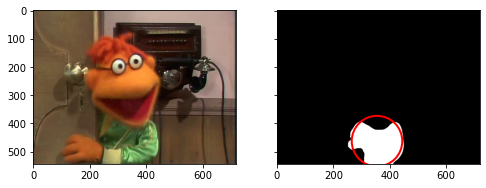

In [460]:
return_green_blobs(imgs[500],plot=True)

## Color Hist

In [562]:
def return_hists(image, plot=False):
    img = image[:,:,::-1].copy() # BGR to RGB
    color = ('r','g','b')
    hists = []
    for i in range(0,3):
        hists.append(cv2.calcHist([img], [i], None, [256], [0,256]).flatten()) 
    hists = np.array(hists)
    if plot:
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(img)
        for i, col in enumerate(color):
            plt.subplot(1,2,2)
            plt.plot(hists[i],color = col)
            plt.xlim([0,256])
        plt.show()
    return(hists)

<ipython-input-562-240e6a30b15d>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)
<ipython-input-562-240e6a30b15d>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


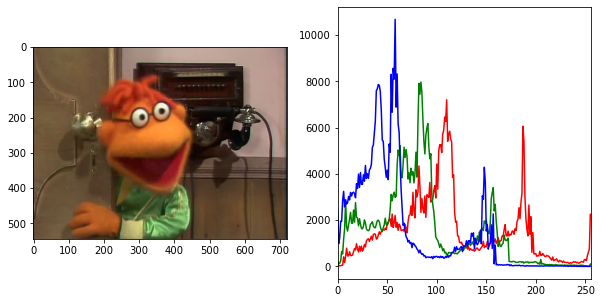

array([[8.5000e+01, 3.3000e+01, 2.9000e+01, 3.0000e+01, 5.1000e+01,
        5.5000e+01, 4.1300e+02, 1.6700e+02, 4.3600e+02, 7.8700e+02,
        4.5900e+02, 4.5700e+02, 6.3500e+02, 4.7000e+02, 4.7000e+02,
        4.9100e+02, 6.2700e+02, 7.7700e+02, 7.1300e+02, 9.8100e+02,
        7.6200e+02, 6.2400e+02, 8.7300e+02, 6.6300e+02, 8.8100e+02,
        6.6000e+02, 7.6400e+02, 9.5100e+02, 8.4700e+02, 1.1110e+03,
        1.1640e+03, 1.1960e+03, 1.0840e+03, 1.1910e+03, 1.3040e+03,
        1.1410e+03, 1.3780e+03, 1.4100e+03, 1.3930e+03, 1.1810e+03,
        1.2130e+03, 1.3640e+03, 1.4950e+03, 1.3930e+03, 1.5060e+03,
        1.5730e+03, 1.5820e+03, 1.5710e+03, 1.6550e+03, 1.5910e+03,
        1.8680e+03, 1.9150e+03, 2.0290e+03, 2.0540e+03, 1.7340e+03,
        2.2640e+03, 1.6830e+03, 1.9050e+03, 2.2040e+03, 1.6930e+03,
        1.8940e+03, 1.5610e+03, 1.8290e+03, 1.7560e+03, 1.5540e+03,
        1.5530e+03, 1.5890e+03, 1.5250e+03, 1.8220e+03, 1.6670e+03,
        1.4510e+03, 1.9180e+03, 2.2050e+03, 2.22

In [564]:
return_hists(imgs[500], plot=True)

---
# DONOTUSE 
# RGB

## Extract Frames

In [6]:
vcap = cv2.VideoCapture('../media/Muppets-02-04-04.avi')
success,image = vcap.read()
count = 0
imgs = []
while success and count < 5000:
#while success:
    #imgs.append(image) # BGR
    imgs.append(image[:, :, ::-1]) #the scikit image way is RGB, openCV is BGR...
    success,image = vcap.read()
    count += 1

(544, 720, 3)


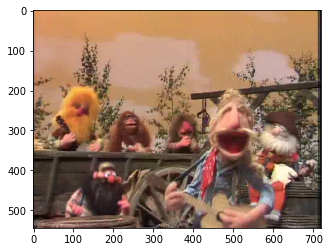

In [417]:
#imgs[2750].shape
test = imgs[4000].copy()
print(test.shape)
plt.imshow(test)


### Extract Color Histograms

(544, 720)


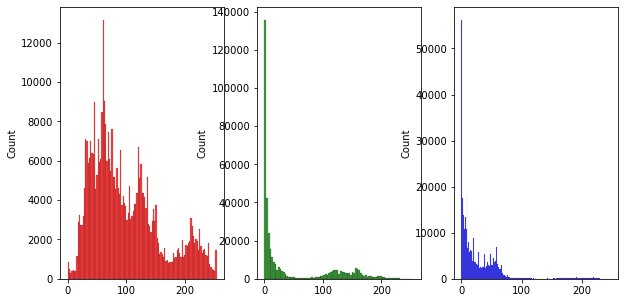

In [249]:
test_g = rgb2gray(test)
#plt.imshow(test)
print(test[:,:,1].shape)
plt.figure(figsize=(10,5))
#plt.hist(test[:,:,1])
col = ["red", "green", "blue"]
for i in range(3):
    plt.subplot(1,3,i+1)
    sns.histplot(test[:,:,i].flatten(), color=col[i]) # plots only one color in histogram
#sns.histplot(data=exposure.histogram(test[:,:,1]),
#             x=exposure.histogram(test[:,:,1])[1],
#             y=exposure.histogram(test[:,:,1])[0])

So the skimage exposure.histogram function is killing the 0 values at the end of the histogram arrays (see below cell), so i build it with numpy instead which is a lil slower but we do not have to fight with different array sizes. Also if we want to look at the whole histogram as one array this will be a whole lot easier to merge...

In [ ]:
print(np.histogram(test[:,:,2], bins=range(257))[0])
print(exposure.histogram(test[:,:,2], nbins=256)[0])

In [302]:
def np_channels():
    for img in range (2500,2600):
        test = imgs[img].copy()
        for i in range(3):
            print(test[:,:,i].size, np.histogram(test[:,:,i], bins=range(257))[0].size)
        print("---")

def ski_channels():
    for img in range (2500,2600):
        test = imgs[img].copy()
        for i in range(3):
            print(test[:,:,i].size, exposure.histogram(test[:,:,i], nbins=256)[0].size)
        print("---")
        
%timeit np_channels
%timeit ski_channels

19.8 ns ± 0.146 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)
16.8 ns ± 0.23 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


In [317]:
testR = np.histogram(test[:,:,0], bins=range(257))
testG = np.histogram(test[:,:,1], bins=range(257))
testB = np.histogram(test[:,:,2], bins=range(257))
print(testR[0].size)
testRGB = np.append((np.append(testR[0], testG[0])), testB[0])
testRGB.size

256


768

### Blob Detection

In [357]:
test_gray = rgb2gray(test[:,:,1])
print(np.max(test_gray)/255)
test_scale = np.interp(test[:,:,1], (0, 255), (0, 1))
print(np.max(test_scale))

0.9882352941176471
0.9882352941176471


<ipython-input-357-27cf53142c4a>:1: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  test_gray = rgb2gray(test[:,:,1])


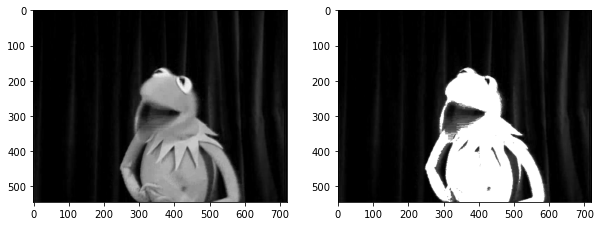

In [358]:
from skimage.feature import blob_doh
test = imgs[2500].copy()
test_green = test.copy()
test_green[test_green[:,:,1]>100] = [0,255,0]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(test[:,:,1], cmap="gray")
plt.subplot(1,2,2)
plt.imshow(test_green[:,:,1], cmap="gray")

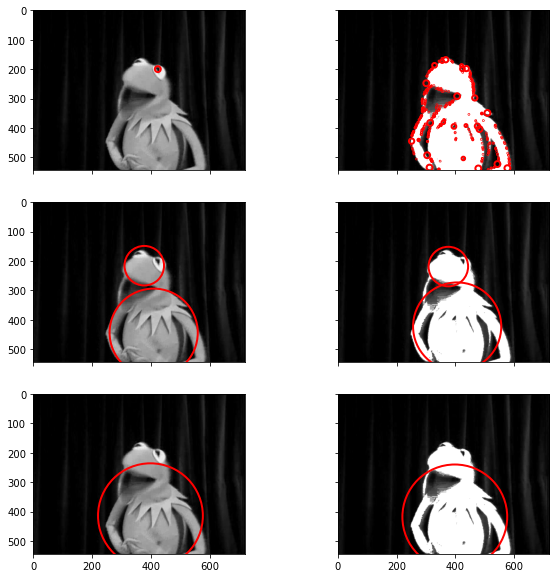

In [410]:
sigma = [10,150,400]
t=0.01

fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()

for i,s in zip(range(0,6,2),sigma):
    blobs_doh = blob_doh(test[:,:,1], max_sigma=s, threshold=t)
    ax[i].imshow(test[:,:,1], cmap="gray")
    for blob in blobs_doh:
        y, x, r = blob
        c = plt.Circle((x, y), r, color="red", linewidth=2, fill=False)
        ax[i].add_patch(c)

    blobs_doh2 = blob_doh(test_green[:,:,1], max_sigma=s, threshold=t)
    ax[i+1].imshow(test_green[:,:,1], cmap="gray")
    for blob in blobs_doh2:
        y, x, r = blob
        c = plt.Circle((x, y), r, color="red", linewidth=2, fill=False)
        ax[i+1].add_patch(c)

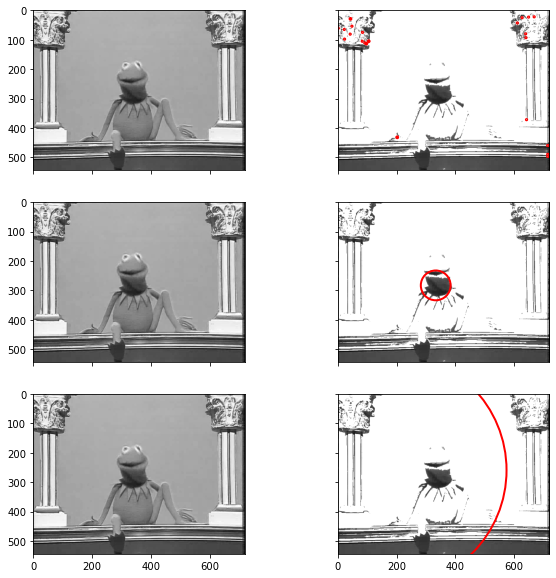

In [425]:
# frame 2500 good example
# frame 3100 bad example (lamp introduces noise)
# frame

from skimage.feature import blob_doh
test = imgs[1750].copy()
test_green = test.copy()
test_green[test_green[:,:,1]>100] = [0,255,0]

sigma = [10,150,400]
t=0.03

fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()

for i,s in zip(range(0,6,2),sigma):
    blobs_doh = blob_doh(test[:,:,1], max_sigma=s, threshold=t)
    ax[i].imshow(test[:,:,1], cmap="gray")
    for blob in blobs_doh:
        y, x, r = blob
        c = plt.Circle((x, y), r, color="red", linewidth=2, fill=False)
        ax[i].add_patch(c)

    blobs_doh2 = blob_doh(test_green[:,:,1], max_sigma=s, threshold=t)
    ax[i+1].imshow(test_green[:,:,1], cmap="gray")
    for blob in blobs_doh2:
        y, x, r = blob
        c = plt.Circle((x, y), r, color="red", linewidth=2, fill=False)
        ax[i+1].add_patch(c)